# 以LSTM/GRU演算法預測股價
### 程式修改自[Predicting stock prices with LSTM](https://medium.com/neuronio/predicting-stock-prices-with-lstm-349f5a0974d4)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ln -fs /content/gdrive/My\ Drive/DL_Book /app
!ln -fs /content/gdrive/My\ Drive /driver
%cd /driver

/content/gdrive/My Drive


In [3]:
!tar -xzf cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# 檢查是否安裝成功
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [4]:
%cd /app
!ls

/content/gdrive/My Drive/DL_Book
 audio		    images_Object_Detection   src
 cascade_files	    images_ocr		      static
 chatbot_data	    images_test		      style_transfer
 Custom_data	    jieba		     'Tensorflow 安裝.md'
 data		    lib			      TicTacToe_1
 data_download.md   MaskRCNN_weights	      video
 data.zip	    myDigits		      YOLO4
 dialogflow	    NLP_data		      YOLO_weights
 FAQ		    rasa		      勘誤表.md
 images		    README.md		      封面1.jpeg
 images_face	    RNN


In [5]:
# 載入相關套件
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# 載入測試資料 -- 亞馬遜
df = pd.read_csv('./RNN/AMZN_2006-01-01_to_2018-01-01.csv', 
                 index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [7]:
df.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN
2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN
2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,AMZN


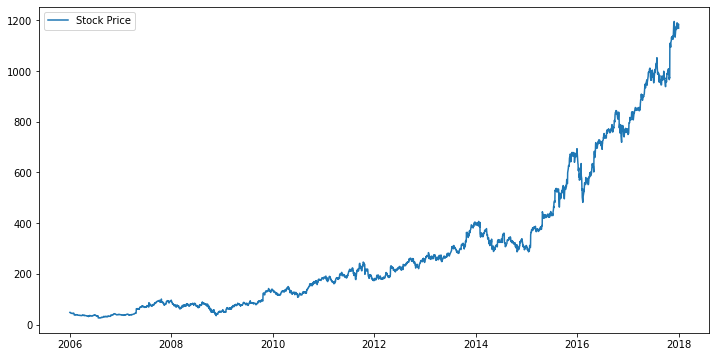

In [8]:
# 只使用收盤價
df = df['Close']

# 繪圖
plt.figure(figsize = (12, 6))
plt.plot(df, label='Stock Price')
plt.legend(loc='best')
plt.show()

In [9]:
# 參數設定
look_back = 40    # 以過去 40 期為特徵(X)
forward_days = 10 # 一次預測 10 天 (y)
num_periods = 20  # 測試資料量設定 20 期

In [10]:
# 特徵常態化
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = df.values.reshape(df.shape[0],1)
array = scl.fit_transform(array)

In [11]:
# 前置處理函數，取得模型輸入的格式
# look_back：特徵(X)個數，forward_days：目標(y)個數，jump：移動視窗
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [12]:
# 資料切割成訓練資料及測試資料
# 一次預測 10 天，共 20 期
division = len(array) - num_periods*forward_days

# 再往前推 40 天當第一筆的 X
array_test = array[division-look_back:]
array_train = array[:division]

In [13]:
# 前置處理、資料切割
# 測試資料前置處理，注意最後一個參數，一次預測 10天，不重疊
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

# 訓練資料前置處理
X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

# 資料切割成訓練資料及驗證資料
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20)

In [14]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(2216, 40, 1)
(554, 40, 1)
(20, 40, 1)

(2216, 10)
(554, 10)
(20, 10)


In [15]:
# 訓練模型
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 10

# 模型
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

# 訓練
history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate)
                    ,shuffle=True,batch_size=2, verbose=2)

Epoch 1/10
1108/1108 - 31s - loss: 0.0017 - val_loss: 4.1429e-04
Epoch 2/10
1108/1108 - 21s - loss: 4.3364e-04 - val_loss: 3.5628e-04
Epoch 3/10
1108/1108 - 21s - loss: 3.3537e-04 - val_loss: 3.1492e-04
Epoch 4/10
1108/1108 - 22s - loss: 2.8683e-04 - val_loss: 2.5078e-04
Epoch 5/10
1108/1108 - 21s - loss: 2.8815e-04 - val_loss: 1.8201e-04
Epoch 6/10
1108/1108 - 22s - loss: 2.5959e-04 - val_loss: 1.7794e-04
Epoch 7/10
1108/1108 - 22s - loss: 2.4595e-04 - val_loss: 3.6573e-04
Epoch 8/10
1108/1108 - 22s - loss: 2.7129e-04 - val_loss: 4.0321e-04
Epoch 9/10
1108/1108 - 22s - loss: 2.3384e-04 - val_loss: 4.1003e-04
Epoch 10/10
1108/1108 - 21s - loss: 2.2655e-04 - val_loss: 1.6884e-04


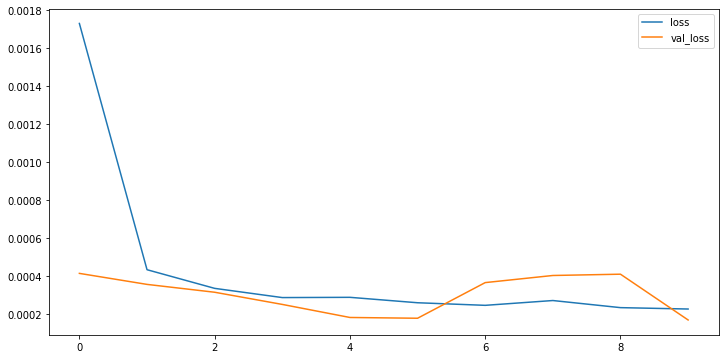

In [16]:
# 繪製損失函數
plt.figure(figsize = (12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [17]:
model.save('./RNN/stock.h5')

## 一次預測 1天：jump=1

(200, 10)


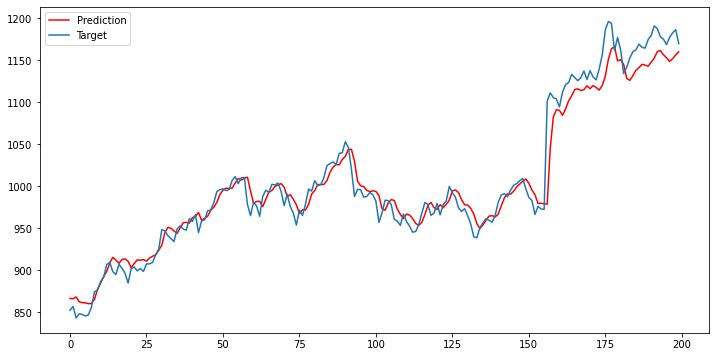

In [18]:
# 前置處理、資料切割
# 測試資料前置處理，注意最後一個參數，一次預測 1天
X_test,y_test = processData(array_test,look_back,1,1)
y_test = np.array([list(a.ravel()) for a in y_test])
        
# 測試資料預測
Xt = model.predict(X_test)
print(Xt.shape)

Xt = Xt[:, 0]

# 繪製測試資料預測值
plt.figure(figsize = (12, 6))
# 繪製 1 條預測值，scl.inverse_transform：還原常態化
plt.plot(scl.inverse_transform(Xt.reshape(-1,1)), color='r', label='Prediction')

# 繪製實際值
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

In [19]:
# 測試資料前置處理，注意最後一個參數，一次預測 10天，移動視窗不重疊
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

# 測試資料預測
Xt = model.predict(X_test)
Xt.shape

(20, 10)

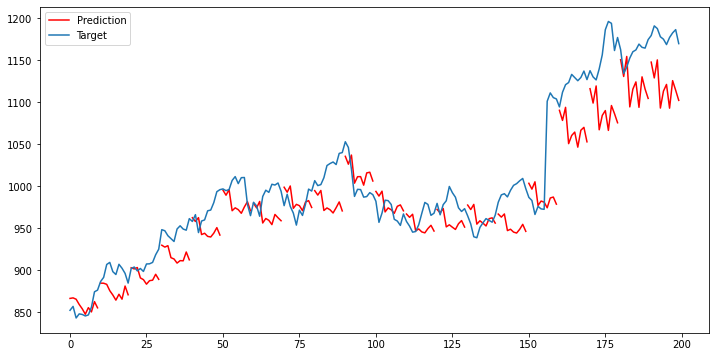

In [20]:
# 繪製測試資料預測值
plt.figure(figsize = (12, 6))
# 繪製 20 條預測值，scl.inverse_transform：還原常態化
for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], 
             scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')

# 指定預測值 label    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r'
         , label='Prediction') 

# 繪製實際值
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

## 全部資料預測

In [21]:
# 全部資料預測
division = len(array) - num_periods*forward_days
array_test = array[division-look_back:]

# 去掉不能整除的資料，取完整的訓練資料
leftover = division%forward_days+1
array_train = array[leftover:division]

Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

# 預測
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel() # 轉成一維

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel() # 轉成一維

# 合併訓練資料與測試資料
y = np.concatenate((ytrain, ytest), axis=0)

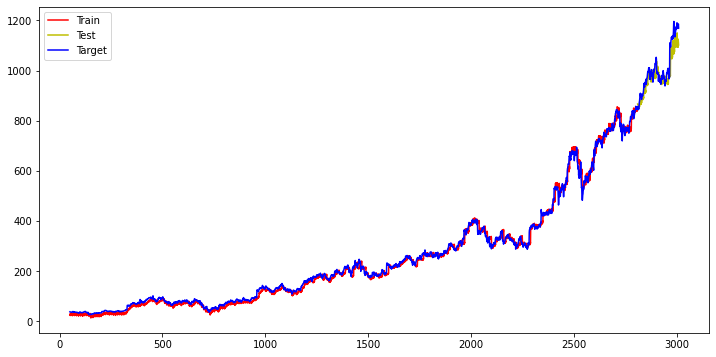

In [22]:
# 繪製訓練資料預測值
plt.figure(figsize = (12, 6))
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], 
         scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# 繪製測試資料預測值
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), 
         len(Xtrain)+len(Xtest)+look_back+leftover)], 
         scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

# 繪製實際值
plt.plot([x for x in range(look_back+leftover, 
                           look_back+leftover+len(Xtrain)+len(Xtest))], 
         scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

plt.legend(loc='best')
plt.show()

## 看起來很好，可是拉近看

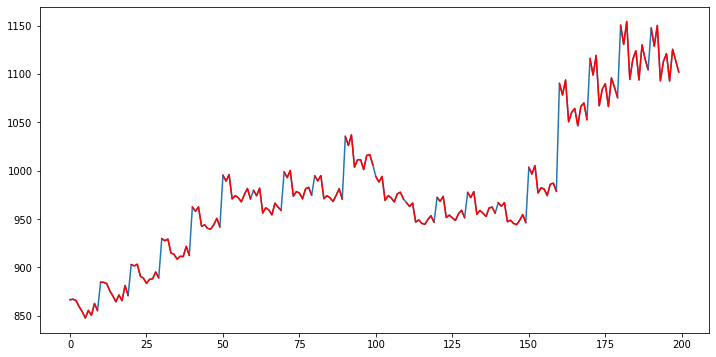

In [23]:
# 繪製測試資料預測值
plt.figure(figsize = (12, 6))
# 全部連成一線
plt.plot(scl.inverse_transform(Xtest.reshape(-1,1)))
# 畫20條線
for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], 
             scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')

## 改用 GRU 模型

In [24]:
from tensorflow.keras.layers import GRU

model_GRU = Sequential()
model_GRU.add(GRU(NUM_NEURONS_FirstLayer,input_shape=(look_back,1)
                  , return_sequences=True))
model_GRU.add(GRU(NUM_NEURONS_SecondLayer
                  ,input_shape=(NUM_NEURONS_FirstLayer,1)))
model_GRU.add(Dense(forward_days))
model_GRU.compile(loss='mean_squared_error', optimizer='adam')

history = model_GRU.fit(X_train,y_train,epochs=EPOCHS
                    ,validation_data=(X_validate,y_validate)
                    ,shuffle=True,batch_size=2, verbose=2)

Epoch 1/10
1108/1108 - 24s - loss: 0.0019 - val_loss: 2.7020e-04
Epoch 2/10
1108/1108 - 22s - loss: 2.9427e-04 - val_loss: 3.2574e-04
Epoch 3/10
1108/1108 - 21s - loss: 2.8029e-04 - val_loss: 2.3879e-04
Epoch 4/10
1108/1108 - 21s - loss: 2.5853e-04 - val_loss: 1.5204e-04
Epoch 5/10
1108/1108 - 22s - loss: 2.6076e-04 - val_loss: 3.4067e-04
Epoch 6/10
1108/1108 - 22s - loss: 2.3556e-04 - val_loss: 2.4083e-04
Epoch 7/10
1108/1108 - 21s - loss: 2.2623e-04 - val_loss: 2.7044e-04
Epoch 8/10
1108/1108 - 21s - loss: 2.2042e-04 - val_loss: 1.4601e-04
Epoch 9/10
1108/1108 - 21s - loss: 2.2460e-04 - val_loss: 1.8788e-04
Epoch 10/10
1108/1108 - 21s - loss: 2.0873e-04 - val_loss: 1.4340e-04
